In [1]:
import numpy as np

import math 

from ad import adnumber, jacobian

from ad.admath import * 

## Car Packing Problem 

Huber loss parameters:

In [2]:
p_x = 0.1
p_y = 0.1
p_theta = 0.01
p_v = 1

p = np.array([p_x, p_y, p_theta, p_v])

State and control loss parameters:

In [3]:
c_w = 0.01
c_a = 0.0001

Euler schema function:

In [4]:
def F(x, y, delta, v, w, a) -> "R^4*":
    f = h*v
    b = f*math.cos(w) + d - math.sqrt(d**2 - f**2 * math.sin(w)**2)

    x = x + b*math.cos(delta)
    y = y + b*math.sin(delta)
    delta = delta + math.asin(math.sin(w) * f/d)
    v = v + h*a
    
    return np.array([x, y, delta, v])

Function to compute differentials of F - Euler schema function:

In [5]:
def DF(x, y, delta, v, w, a) -> "R^4*6, R^4*6*6":
    """Compute the jacobian matrix and hessian tensor of Euler step."""
    x, y, delta, v, w, a = adnumber([x, y, delta, v, w, a])
    
    f = h*v
    b = f*cos(w) + d - sqrt(d**2 - f**2 * sin(w)**2)

    F_x = x + b*cos(delta)
    F_y = y + b*sin(delta)
    F_delta = delta + asin(sin(w) * f/d)
    F_v = v + h*a
    
    jaco = np.array(jacobian([F_x, F_y, F_delta, F_v], [x, y, delta, v, w, a]))
    
    H_x = F_x.hessian([x, y, delta, v, w, a])
    H_y = F_y.hessian([x, y, delta, v, w, a])
    H_delta = F_delta.hessian([x, y, delta, v, w, a])
    H_v = F_v.hessian([x, y, delta, v, w, a])
    
    hess = np.array([H_x, H_y, H_delta, H_v])
    
    return jaco, hess

Function to compute differentials of state-control loss:

In [6]:
def DL(x, y, delta, v, w, a) -> "R^6, R^6*6":
    """Compute the gradient vector and hessian matrix of loss function."""
    x, y, delta, v, w, a = adnumber([x, y, delta, v, w, a])
    
    z_x = sqrt(x**2 + p_x**2) - p_x
    z_y = sqrt(y**2 + p_y**2) - p_y
    z_delta = sqrt(delta**2 + p_theta**2) - p_theta
    z_v = sqrt(v**2 + p_v**2) - p_v
    
    L = 0.01*(z_x + z_y) + c_w * w**2 + c_a * a**2
    
    return np.array(L.gradient([x, y, delta, v, w, a])), np.array(L.hessian([x, y, delta, v, w, a]))

Functions to compute differentials of final loss:

In [7]:
def D_Lf(x, y, delta, v) -> "R^4, R^4*4":
    """Compute the gradient vector and hessian matrix of final loss."""
    x, y, delta, v= adnumber([x, y, delta, v])

    z_x = sqrt(x**2 + p_x**2) - p_x
    z_y = sqrt(y**2 + p_y**2) - p_y
    z_delta = sqrt(delta**2 + p_theta**2) - p_theta
    z_v = sqrt(v**2 + p_v**2) - p_v

    L_F = ( z_x + z_y + z_delta + z_v)
    
    return np.array(L_F.gradient([x, y, delta, v])), np.array(L_F.hessian([x, y, delta, v]))


In [8]:
def z(x, p):
    return math.sqrt(x**2 + p**2) - p
def Lf(x, y, theta, v) -> "R":
    return  (z(x, p_x) + z(y, p_y) + z(theta, p_theta) + z(v, p_v))
# def L(x, y, theta, v, w, a) -> "R":
#     return 0.01*(z(x, p_x) + z(y, p_y)) + c_w * w**2 + c_a * a**2

# def V_star(i, ui, X, U):
#     X_res = [F(*X[i], *ui)]
#     for j in range(i+1, N-1):
#         X_res.append(F(*X_res[-1], *U[j]))
#     return L(*X[i], *ui) + sum([L(*X_res[j-(i+1)], *U[j]) for j in range(i+1, N-1)]) + Lf(*X_res[-1])

# def line_search(f, gradient, x, direction, a = 0.25, b = 0.5) -> "step":
#     """Backtracking line search."""
#     m = direction.shape[0]
#     t = 1
#     while f(x + t*direction) > f(x) + a*t*gradient@direction or f(x + t*direction) == -np.inf:
# #         print(x)
#         t = b*t
# #     print(f(x + t*direction))
#     return t

Optimization initial settings:

In [17]:
from scipy.signal import unit_impulse
basis = [unit_impulse(6,i) for i in range(6)]

T = 10; N = 1000; h = T/N; 
# p = np.zeros(4)
X = np.array(N * [[1, 1, 3/2*pi, 0]])
U = np.zeros((N,2))

d = 4

In [18]:
X

array([[1.        , 1.        , 4.71238898, 0.        ],
       [1.        , 1.        , 4.71238898, 0.        ],
       [1.        , 1.        , 4.71238898, 0.        ],
       ...,
       [1.        , 1.        , 4.71238898, 0.        ],
       [1.        , 1.        , 4.71238898, 0.        ],
       [1.        , 1.        , 4.71238898, 0.        ]])

* Calculus of differentials of final loss:

In [19]:
gradient_Lf, hessian_Lf = D_Lf(*X[-1])

DVstar_list_inv = [gradient_Lf] #DV*_{n-1}(x_{n-1})
D2Vstar_list_inv = [hessian_Lf]

DV_list_inv = []
D2V_list_inv = []

* Backward pass

In [20]:
#backward pass, begin with DV_n-2
for t in range(N-2, -1, -1): #from N-2 to 0
    
    gradient_L, hessian_L = DL(*X[t], *U[t])
    jacobian_F, hessian_F = DF(*X[t], *U[t])
    DV = gradient_L + DVstar_list_inv[-1] @ jacobian_F
    D2V = np.reshape([ei @ hessian_L @ ej + 
                      DVstar_list_inv[-1] @ (ej @ hessian_F @ ei) + 
                      (jacobian_F @ ej) @ D2Vstar_list_inv[-1] @ (jacobian_F @ ei) for ei in basis for ej in basis], (6,6))

    DV_list_inv.append(DV)
    D2V_list_inv.append(D2V)
    
    DVstar = DV[:4] + DV[4:] @ np.linalg.inv(D2V[4:, 4:]) @ D2V[4:, :4]
    D2Vstar = D2V[:4, :4] + D2V[:4, 4:] @ np.linalg.inv(D2V[4:, 4:]) @ D2V[4:, :4]
   
    DVstar_list_inv.append(DVstar)
    D2Vstar_list_inv.append(D2Vstar)

* Forward pass

In [21]:
DV = DV_list_inv[::-1]
D2V = D2V_list_inv[::-1]

X_hat = np.copy(X)
#forward pass
for t in range(N-1):
    if t == 0:
        h_u = -np.linalg.inv(D2V[t][4:, 4:]) @ DV[t][4:]
        U[t] = U[t] + h_u
        X_hat[t+1] = F(*X_hat[t], *U[t])
    else:
        h_x = X_hat[t] - X[t]
        h_u = -np.linalg.inv(D2V[t][4:, 4:]) @ (DV[t][4:] + D2V[t][4:, :4] @ h_x)
        U[t] = U[t] + h_u
        X_hat[t+1] = F(*X_hat[t], *U[t])

In [13]:
import matplotlib.pyplot as plt 

In [22]:
X_hat

array([[1.        , 1.        , 4.71238898, 0.        ],
       [       nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan],
       ...,
       [       nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan]])

In [24]:
DV

[array([nan, nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan, nan]),


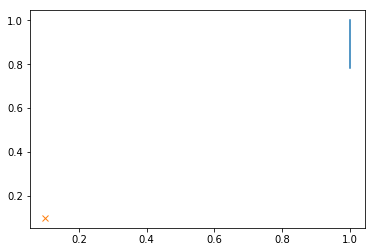

In [38]:
plt.plot(X_hat[:, 0], X_hat[:, 1])
plt.plot(p[0], p[1], marker = 'x')

In [11]:
X_hat = X

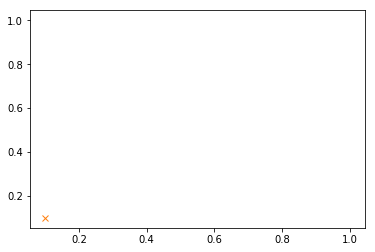

nan
[nan nan nan nan]


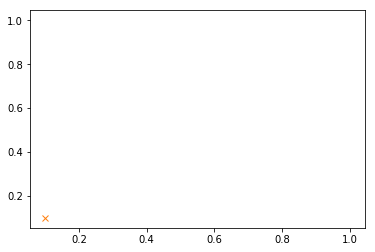

nan
[nan nan nan nan]


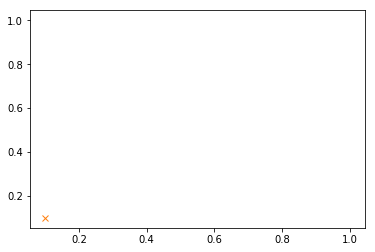

nan
[nan nan nan nan]


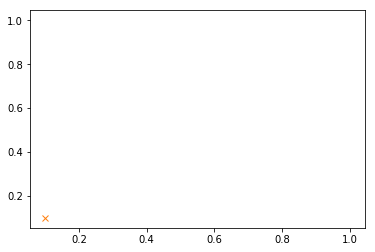

nan
[nan nan nan nan]


KeyboardInterrupt: 

In [14]:
n = 300
for _ in range(n):
    
    X = X_hat
    
    gradient_Lf, hessian_Lf = D_Lf(*X[-1])

    DVstar_list_inv = [gradient_Lf] #DV*_{n-1}(x_{n-1})
    D2Vstar_list_inv = [hessian_Lf]

    DV_list_inv = []
    D2V_list_inv = []

    #backward pass, begin with DV_n-2
    for t in range(N-2, -1, -1): #from N-2 to 0

        gradient_L, hessian_L = DL(*X[t], *U[t])
        jacobian_F, hessian_F = DF(*X[t], *U[t])
        DV = gradient_L + DVstar_list_inv[-1] @ jacobian_F
        D2V = np.reshape([ei @ hessian_L @ ej + 
                          DVstar_list_inv[-1] @ (ej @ hessian_F @ ei) + 
                          (jacobian_F @ ej) @ D2Vstar_list_inv[-1] @ (jacobian_F @ ei) for ei in basis for ej in basis], (6,6))

        DV_list_inv.append(DV)
        D2V_list_inv.append(D2V)

        DVstar = DV[:4] + DV[4:] @ np.linalg.inv(D2V[4:, 4:]) @ D2V[4:, :4]
        D2Vstar = D2V[:4, :4] + D2V[:4, 4:] @ np.linalg.inv(D2V[4:, 4:]) @ D2V[4:, :4]

        DVstar_list_inv.append(DVstar)
        D2Vstar_list_inv.append(D2Vstar)

    DV = DV_list_inv[::-1]
    D2V = D2V_list_inv[::-1]

    X_hat = np.copy(X)
    #forward pass
    for t in range(N-1):
        if t == 0:
            h_u = - np.linalg.inv(D2V[t][4:, 4:]) @ DV[t][4:]
            U[t] = U[t] + h_u
            X_hat[t+1] = F(*X_hat[t], *U[t])
        else:
            h_x = X_hat[t] - X[t]
            h_u = - np.linalg.inv(D2V[t][4:, 4:]) @ (DV[t][4:] + D2V[t][4:, :4] @ h_x)
            U[t] = U[t] + h_u
            X_hat[t+1] = F(*X_hat[t], *U[t])
            
    
            
    plt.plot(X_hat[:, 0], X_hat[:, 1])
    plt.plot(p[0], p[1], marker = 'x')
    plt.pause(0.05)
    
    
    dis = Lf(*X_hat[-1])
    if dis < 0.01:
        break
    else: 
        print(dis)
        print(X_hat[-1])
    
plt.show()

In [20]:
X_hat[-1]

array([1.02746119, 0.95112712, 5.07533981, 0.06510141])

In [21]:
p_ = [0.1, 0.1, 3/2*pi, 0]

In [40]:
np.linalg.norm(p_[:2] -X_hat[-1, :2] )

1.2588096082482172

In [41]:
np.linalg.norm(p_ -X_hat[-1] )

1.3117061907983711

In [100]:
Lf(*(X_hat[-1] ) )

7754.684520218046

In [92]:
X_hat[-1]

array([8.70876227e-02, 1.20383716e-02, 7.73134932e+00, 1.48221238e-03])

In [70]:
U

array([[ 0.00000000e+00,  7.17997288e+02],
       [ 9.94639754e+09, -2.91938363e+00],
       [ 7.88471886e+09,  1.64436589e+00],
       [ 6.25792983e+09,  1.25052256e+00],
       [ 4.96709016e+09, -2.78834201e+00],
       [ 3.94230330e+09,  1.38521090e+00],
       [ 3.12906715e+09,  1.49765552e-01],
       [ 2.48360294e+09,  1.16000134e-01],
       [ 1.97111987e+09, -1.06122599e-01],
       [ 1.56451766e+09, -7.43620715e-02],
       [ 1.24175654e+09, -9.04801039e-02],
       [ 9.85472908e+08, -8.13971719e-01],
       [ 7.82155123e+08,  2.57522800e-01],
       [ 6.20914278e+08,  2.69158919e-03],
       [ 4.93260876e+08,  6.56625032e-01],
       [ 3.91119484e+08, -8.09160485e-02],
       [ 3.10529998e+08, -5.92219135e-01],
       [ 2.46382625e+08,  1.07371456e-01],
       [ 1.95562284e+08, -8.30565936e-02],
       [ 1.55222846e+08, -7.64542485e-02],
       [ 1.23334430e+08,  1.09365300e+00],
       [ 9.77907085e+07,  1.46645468e-01],
       [ 7.76386766e+07,  1.31716872e+00],
       [ 6.

In [12]:
# basis[0] @ np.array([np.eye(6), np.eye(6), np.eye(6)]) @ basis[0]
# A = np.random.rand(4, 6, 6)
# b = np.random.rand(6)
# c = np.random.rand(6)

# c@ A @ b == np.array([c @a @b for a in A])

# c@ A @ b

# np.array([c @a @b for a in A])

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'acos',
 'acosh',
 'acot',
 'acoth',
 'acsc',
 'acsch',
 'admath',
 'asec',
 'asech',
 'asin',
 'asinh',
 'atan',
 'atan2',
 'atanh',
 'ceil',
 'cos',
 'cosh',
 'cot',
 'coth',
 'csc',
 'csch',
 'degrees',
 'e',
 'erf',
 'erfc',
 'exp',
 'expm1',
 'fabs',
 'factorial',
 'floor',
 'gamma',
 'hypot',
 'isinf',
 'isnan',
 'lgamma',
 'ln',
 'log',
 'log10',
 'log1p',
 'phase',
 'pi',
 'polar',
 'pow',
 'radians',
 'rect',
 'sec',
 'sech',
 'sin',
 'sinh',
 'sqrt',
 'tan',
 'tanh',
 'trunc']